In [6]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from operator import itemgetter
import time
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import gc


## Wczytanie zbioru danych
W tej lekcji wykorzystamy zbiór German Credit pochodzący z UCI (https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). Na tym etapie nie interesuje nas proces selekcji zmiennych do modelu. Skorzystamy więc z pełnego zbioru. Zaletą korzystanie z XGB jest brak konieczności przekształcania i kodowania zmiennych porządkowych. Cała nasza praca ze zbiorem ogranicza się więc do poprawienia zmiennej objaśnianej i zapisania listy zmiennych do wykorzystania.

In [7]:
medical = pd.read_pickle("datasets/medical.p")
print(medical.UCURNINS.unique())
medical["UCURNINS"] = (medical.UCURNINS=="Yes").astype(int)
print(medical.UCURNINS.unique())

levCols = ["UMARSTAT", "USATMED", "URELATE",
                      "REGION", "FHOSP", "UIMMSTAT",
                      "U_FTPT", "UBRACE", "UEDUC3",
                      "GENDER"]

numCols = ["FDENT", "FEMER", "FDOCT", "UAGE",
                     "U_WKSLY", "U_USHRS", "U_HRSLY"]
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in levCols:
    medical[col] = le.fit_transform(medical[col])
features = levCols + numCols

['Yes' 'No']
[1 0]


## Wrapper dla XGBoost
XGBoost posiada dobrze udokumentowane API dla Pythona (http://xgboost.readthedocs.io/en/latest/python/python_api.html), które pozwala na pracę z XGB na dwa sposoby:
* opierając się o API standaryzowane dla sklearn, który zawiera osobne moduły dla regresji i klasyfikacji
* opierając się o uniwersalny obiekt train

Wydaje się, że elastyczniej jest posiadać dobrze skonfigurowany wrapper XGB w oparciu o uniwersalny obiekt train. Poniżej znajduje się przykład takiego wrappera, który pozwala na zastosowanie XGB dla niemalże dowolnego problemu.

Odpowiednie skonsturowany wrapper umożliwia łatwe uruchomienie walidacji krzyżowej, wydobycie pełnej informacji o procesie szkolenia algorytmu oraz łątwe wpięcie w istniejący pipeline ML.

Budowanie kolejnych wersji wrappera krok po kroku byłoby zbyt czasochłonne, dlatego poniżej znajduje się względnie kompletna jego implementacja.

Wszystkie argumenty funkcji zostały rozbite na trzy grupy: obowiązkowych, podstawowych argumentów do turningu hiperparametrów oraz argumentu konfiguracyjne.

In [8]:
def run_xgb(train, validate, features, target,
            eta=0.03, max_depth=7,
            subsample = 0.7, colsample_bytree = 0.7, colsample_bylevel=1,
            lambdaX = 1, alpha=0, gamma=0, min_child_weight=0,
            rate_drop = 0.2, skip_drop=0.5,
            num_boost_round = 1000, early_stopping_rounds = 50,
            verbo=True, eval_metric= ["auc"], objective = "binary:logistic",
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"):
    '''
    Uniwersalny wrapper dla XGB dla gbtree i dart
    Więcej opcji https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    
    Parametry
    ----------
    train, validate, features, target : wymagane zmienne bez domyślnych wartości
    train, validate : pd.DataFrames z kolumnami opisanymi w features i target
    features : lista zmiennych do wykorzystania w trenowaniu
    target : nazwa zmiennej objasnianej
    
    --- Zmienne wspólne dla gbtree i dart
        --- Zmienne właściwe dla Ensamble/Boosting
        eta : "learning rate"
        max_depth=7 : maksymalna głębokość drzew [0,∞]
        subsample : udział (0,1] obserwacji do treningu jednej iteracji
        colsample_bytree : udział (0,1] kolumn do treningu jednej iteracji
        colsample_bylevel : udział  (0,1] kolumn na poziom do treningu jednej iteracji
        --- Zmienne regularyzacyjne
        lambdaX : regularyzacja L2 [0,∞]
        alpha=0 : regularyzacja L1 [0,∞]
        gamma=1 : minimalna redukcja funkcji straty
        min_child_weight : minimalna suma wg poddrzewa

    --- Zmienne dla dart
    rate_drop : 
    skip_drop : 
    
    --- Zmienne dla XGB, opis/agorytm/liczba drzew etc.
    num_boost_round : maksymalna liczba iteracji
    early_stopping_rounds : margines iteracji dla early stopping
    verbo : Czy włączyć pełne opisy.
    eval_metric : Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    objective : reg:linear, reg:logistic, binary:logistic, multi:softmax lub inne Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    seed : random seed
    booster : ‘auto’, ‘exact’, ‘approx’, ‘hist’, ‘gpu_exact’, ‘gpu_hist’- silnik dla drzew gbtree (cart), dart (gbtree z dropoutem) lub gblinear
    tree_method : zobacz http://xgboost.readthedocs.io/en/latest/parameter.html
    grow_policy : depthwise, lossguide
    '''
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(verbo):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=verbo)
    
    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    bestPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(verbo):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, bestPred, train_history, impFig, imp

## Zbiór treningowy i walidacyjny
Do przygotowania zbioru treningowego i walidacyjnego wykorzystamy train_test_split z biblioteki sklrean (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Warto zwrócić uwagę na argument stratify, ktory pozwala losować warstwowo do prób. Zapewnienie odpowiedniej proporcji 1 i 0 w podzbiorach ma ogromne znaczenie, gdyż w wielu przypadkach czyste losowanie może doprowadzić do mocno niereprezentatywnych podprób, a w konsekwencji do obciążonych modeli.

In [9]:
test_size = 0.2
X_train, X_valid = train_test_split(medical, test_size=test_size, random_state=2017, stratify=medical["UCURNINS"].values)

## Pierwszy trening
Kiedy mamy już przygotowane zbiory do treningu i walidacji możemy przystąpić do pierwszego uruchomienia treningu XGB. Wszystkie parametry będą ustawione domyślnie z wyjątkiem early_stopping_rounds, który zwiększymy do 50, aby móc przyjrzeć się temu jak model się przetrenowuje.

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 28057
Length valid: 7015
[0]	train-auc:0.810789	valid-auc:0.776164
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.842384	valid-auc:0.806518
[2]	train-auc:0.852076	valid-auc:0.815187
[3]	train-auc:0.85503	valid-auc:0.815491
[4]	train-auc:0.857354	valid-auc:0.817956
[5]	train-auc:0.858845	valid-auc:0.818359
[6]	train-auc:0.861159	valid-auc:0.820976
[7]	train-auc:0.861768	valid-auc:0.821868
[8]	train-auc:0.863576	valid-auc:0.822253
[9]	train-auc:0.865515	valid-auc:0.824063
[10]	train-auc:0.866366	valid-auc:0.825043
[11]	train-auc:0.867546	valid-

[179]	train-auc:0.908715	valid-auc:0.841093
[180]	train-auc:0.908889	valid-auc:0.84112
[181]	train-auc:0.909066	valid-auc:0.841144
[182]	train-auc:0.909098	valid-auc:0.841095
[183]	train-auc:0.909302	valid-auc:0.841079
[184]	train-auc:0.909575	valid-auc:0.84112
[185]	train-auc:0.909748	valid-auc:0.841145
[186]	train-auc:0.909903	valid-auc:0.841158
[187]	train-auc:0.910016	valid-auc:0.841169
[188]	train-auc:0.910099	valid-auc:0.841219
[189]	train-auc:0.910202	valid-auc:0.841331
[190]	train-auc:0.910439	valid-auc:0.84135
[191]	train-auc:0.910661	valid-auc:0.841328
[192]	train-auc:0.910746	valid-auc:0.841325
[193]	train-auc:0.910916	valid-auc:0.841442
[194]	train-auc:0.911004	valid-auc:0.841509
[195]	train-auc:0.911204	valid-auc:0.841535
[196]	train-auc:0.911305	valid-auc:0.841521
[197]	train-auc:0.911351	valid-auc:0.841506
[198]	train-auc:0.911464	valid-auc:0.841459
[199]	train-auc:0.911499	valid-auc:0.841413
[200]	train-auc:0.911595	valid-auc:0.841369
[201]	train-auc:0.911714	valid-auc:

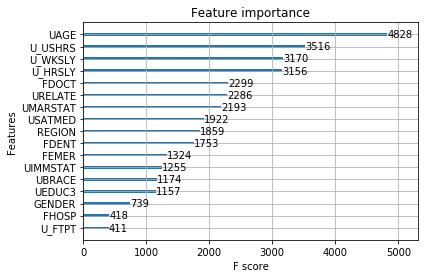

In [10]:
score, bestPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, "UCURNINS", early_stopping_rounds=50)

Jak widać  algorytm bez problemu "przetrenowuje się" (*overfitting*), ale nie bardzo mocno. W miejscu w którym osiągamy największą wartość AUC na zbiorze walidacyjnym obserwujemy AUC dla zbioru treningowego na poziomie 0.927, co ilustruje poniższy wykres.

W przypadku boostowanych drzew decyzyjnych najlepszą metodą na rozwiązanie problemu overfittingu jest zwiększenie treningowego zbioru danych. XGB jest z powodzeniem wykorzystywany na zbiorach danych zawierających setki tysięcy, a nawet miliony obserwacji. Właśnie na takich zbiorach mamy szansę zobaczyć pełnię możliwości algorytmu. Korzyści z lokalnego dopasowania nie są bowiem tak szybko przewyższane problemem przetrenowania.

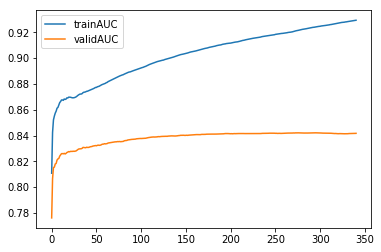

In [11]:
train_history.plot()
plt.show()

## Dobór hiperparametrów
Zagadnienie dobierania hiperparametrów jest bardzo szerokie i stanowi oddzielny temat. Przy okazji omawiania XGB przedstawimy więc ten temat skrótowo. Proces ten należy przeprowadzać stosując walidację krzyżową, będąc w pełni świadomym jej ograniczeń. Aby je dokładnie zrozumieć rozpocznijmy od iteracyjnego dobierania parameterów dla XGB.

Taka procedura pozwoli nam zdobyć intuicyjne rozumienie wpływu poszczególnych parametrów na zachowanie algorytmu, a w konsekwencji zrozumieć dlaczego tak łatwo jest popełnić błąd przetrenowania szukając najlepszych hiperparametrów.

Dla XGB najważniejsze parametry to:
* max_depth
* subsample
* colsample_bytree
* lambda


### Lambda
W sytuacji w której obserwujemy tak silne przetrenowanie i dużą różnice pomiędzy wartościami statystyk w zbiorach treningowych  i testowych powinniśmy w pierwszej kolejności sprawdzić optymalną wielkość dla zmiennych które pomagają zapobiegać przetrenowaniu. W przypadku XGB najlepszym pierwszym krokiem jest zwykle ustalenie odpowiedniego poziomu regularyzacji L2 (lambda). Wybierzemy więc w pierwszej iteracji wartości od 0 do 49 iterując x^2 od 0 do 7. Stosujemy takie podejście ze względu na to, iż w praktyce zakres optymalnych wartości dla lambdy jest bardzo szeroki. Jednocześnie model nie powinien być bardzo wrażliwy na względnie małe zmiany parametrów.

In [12]:
resHists = dict()

rang = range(0,8)
for x in rang:
    score, bestPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, "UCURNINS",
                                                       lambdaX=x**2, early_stopping_rounds=50, verbo=False)
    print(x**2, score)
    resHists[x]=train_history
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

0 0.841886
1 0.842086
4 0.841857
9 0.84263
16 0.843309
25 0.842833
36 0.843365
49 0.843138


Z jednej strony wygląda na to, że podnoszenie lambdy nam pomaga, ale z drugiej poprawa nie jest rewelacyjna. Przyjrzyjmy się innym parametrom ustalając lambdę na poziomie 9. Na czas testowania innych parametrów nie warto ustawiać ekstremalnych wartości.

### Głębokość drzew max_depth
Nie ma typowej wartości dla głębokości drzew. Na niektórych zbiorach może to być 14, na innych 5 lub 4. Przedział 4-14 to dobry początek (dla większych zbiorów danych), który możemy zmienić jeżeli okazałoby się, że dla największych wartości osiągamy najlepsze rezultaty.

4 0.84304
6 0.843468
8 0.842701
10 0.842188
12 0.842295
14 0.841386


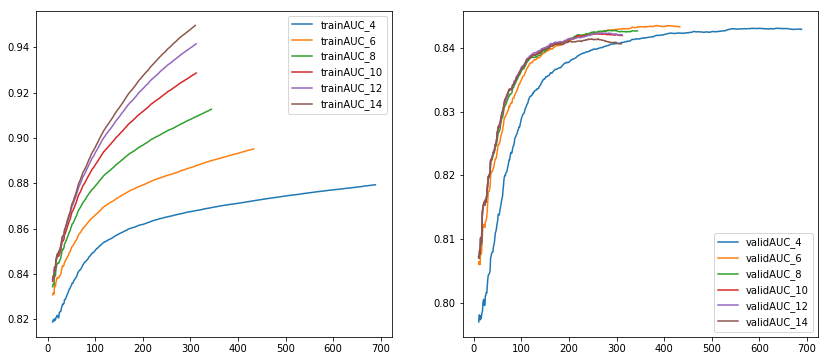

In [13]:
resHists = dict()
rang = range(4,15,2)
for x in rang:
    score, bestPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, "UCURNINS", lambdaX=15,
                                                          max_depth=x, num_boost_round=700, early_stopping_rounds=50,  verbo=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Z jednej strony nie wydaje się aby dobrane przez nas wartości mocno wpływaly na wynik. Widzimy jednak, że dla większych wartości overfitting jest silniejszy, gdyż różnica pomiędzy metryką dla zbioru treningowego i testowego jest większa dla większych głębokości. 6 wydaje się być optymalną wartością na początek.

# Udział wierszy i kolumn.
W drugiej kolejności warto sporzeć na subsample, a następnie colsample_bytree. Znów, trzeba zwrócić uwagę na fakt iż dokonujemy jedynie zapoznania z modelem. Szukając najlepszych parametrów dla XGB musimy być świadomi, iż jest to wielowymiarowa przestrzeń, która zawiera liczne lokalne minima/maksima. Z tego powodu iteracyjna procedura nie gwarantuje optymalności wyniku (więcej o tym poniżej).

In [14]:
resHists = dict()
rang = range(3,10)
for x in rang:
    score, bestPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, "UCURNINS",
                                                          max_depth=6, lambdaX=15, subsample=x/10,
                                                          early_stopping_rounds=50, verbo=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

0.3 0.843088
0.4 0.842997
0.5 0.843223
0.6 0.843388
0.7 0.843468
0.8 0.84392
0.9 0.843346


Wybieranie tylko części wierszy zdaje się nie wprowadzać dużych zmian. Nasz estymator jest bardzo stabilny.

0.3 0.844888
0.4 0.844266
0.5 0.84435
0.6 0.844485
0.7 0.84392
0.8 0.844122
0.9 0.843319


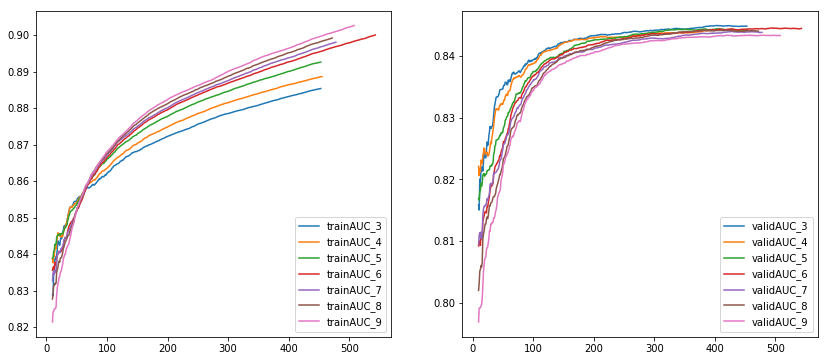

In [15]:
resHists = dict()
rang = range(3,10)
for x in rang:
    score, bestPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, "UCURNINS",
                                                          max_depth=6, lambdaX=15, subsample=0.8, colsample_bytree=x/10,
                                                          early_stopping_rounds=50, verbo=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Z drugiej strony osiągamy zauważalnie lepszy wynik, kiedy wybierzemy naprawdę małą liczbę kolumn dla pojedynczego drzewa.

W niektorych przypadkach warto również spojrzeć na colsample_bylevel, które można ustalać jednocześnie z colsample_bytree lub osobno (colsample_bytree=1).

3 0.843857
4 0.844816
5 0.844535
6 0.844535
7 0.844643
8 0.844643
9 0.844482
10 0.844266


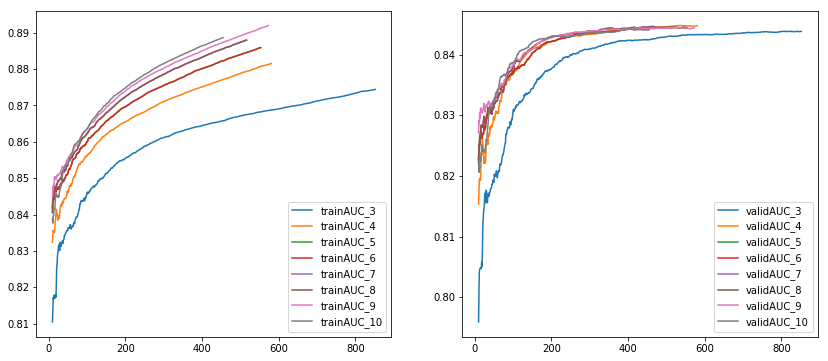

In [16]:
resHists = dict()
rang = range(3,11)
for x in rang:
    score, bestPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, "UCURNINS",
                                                          max_depth=6, lambdaX=15, subsample=0.8, colsample_bytree=0.4, colsample_bylevel=x/10,
                                                          early_stopping_rounds=50, verbo=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

In [19]:
resHists = dict()
rang = range(3,11)
for x in rang:
    score, bestPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, "UCURNINS",
                                                          max_depth=6, lambdaX=9, subsample=0.6, colsample_bytree=1, colsample_bylevel=x/10,
                                                          early_stopping_rounds=50, verbo=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

3 0.843819
4 0.842888
5 0.843149
6 0.842553
7 0.843552
8 0.843419
9 0.843442
10 0.843839


Jak widać w tym przypadku tego zbioru warto zostawić colsample_bylevel na domyślnym poziomie.

### Gamma - inny sposób na walkę z przetrenowaniem.
Na niektórych zbiorach dobranie odpowiedniej wielkości dla gamma pozwala na uzyskanie zdecydowanie lepszych rezultatów niż manipulacja lambdą. Warto zmniejszyć wielkość Lambda, kiedy wprowadzamy dodatkową regularyzację.